In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

# Leitura dos dados

In [38]:
df = pd.read_csv('titanic.csv')

In [39]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [40]:
df.shape

(891, 12)

# Organizando dados

In [41]:
#Group age into 4 buckets
def age_config(allset):
    allset['AgeBand']=''
    allset.loc[allset['Age']<=1,'AgeBand']='Infant'
    allset.loc[(allset['Age']>1) & (allset['Age']<=10),'AgeBand']='YoungChild'
    allset.loc[(allset['Age']>10) & (allset['Age']<=60),'AgeBand']='Adults'
    allset.loc[allset['Age']>60,'AgeBand']='Seniors'
    
    return allset

df = age_config(df)

In [42]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Adults
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adults
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Adults
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Adults
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Adults


In [43]:
df = pd.concat([df.drop(['Sex'], axis=1), pd.get_dummies(df['Sex'])], axis=1)
df = pd.concat([df.drop(['Pclass'], axis=1), pd.get_dummies(df['Pclass'])], axis=1)
df = pd.concat([df.drop(['AgeBand'], axis=1), pd.get_dummies(df['AgeBand'])], axis=1)

In [51]:
X.head()

,Fare,female,male,1,2,3,,Adults,Infant,Seniors,YoungChild
0,7.2500,0,1,0,0,1,0,1,0,0,0
1,71.2833,1,0,1,0,0,0,1,0,0,0
2,7.9250,1,0,0,0,1,0,1,0,0,0
3,53.1000,1,0,1,0,0,0,1,0,0,0
4,8.0500,0,1,0,0,1,0,1,0,0,0


In [50]:
X.isna().sum()

Fare          0
female        0
male          0
1             0
2             0
3             0
              0
Adults        0
Infant        0
Seniors       0
YoungChild    0
dtype: int64

# Separando em dados de treinamento e teste

In [48]:
X = df.drop(['Survived', 'PassengerId', 'Age', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin','Embarked'], axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [52]:
X_train.head()

,Fare,female,male,1,2,3,,Adults,Infant,Seniors,YoungChild
570,10.5000,0,1,0,1,0,0,0,0,1,0
787,29.1250,0,1,0,0,1,0,0,0,0,1
74,56.4958,0,1,0,0,1,0,1,0,0,0
113,9.8250,1,0,0,0,1,0,1,0,0,0
635,13.0000,1,0,0,1,0,0,1,0,0,0


In [66]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=7, random_state=0)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [69]:
%time
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=7, random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [73]:
CV_rfc.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=500,
                       random_state=0)

In [70]:
#logreg.fit(X_train, y_train)

Y_Pred = CV_rfc.predict(X_test)
acc_log = round(CV_rfc.score(X_train, y_train) * 100, 2)
acc_log

84.08

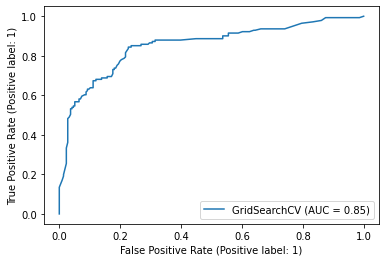

In [71]:
svc_disp = plot_roc_curve(CV_rfc, X_test, y_test)
plt.show()

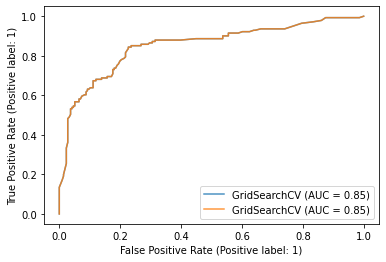

In [72]:

ax = plt.gca()
rfc_disp = plot_roc_curve(CV_rfc, X_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()